In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('dark_background')

In [2]:
df = pd.read_csv('Clean_HSI.csv') 
df.head()

,Date,Open,High,Low,Close,Up votes,Down votes
0,2022-02-24,23268.03,23376.37,22786.39,22901.56,0.69,0.31
1,2022-02-25,22908.10,23046.86,22718.15,22767.18,0.36,0.64
2,2022-02-28,22818.17,22818.17,22406.12,22713.02,0.61,0.39
3,2022-03-01,22739.84,22937.56,22591.73,22761.71,0.49,0.51
4,2022-03-02,22568.36,22712.44,22299.14,22343.92,0.48,0.52


In [3]:
# For MACD backtesting, we simply need Close 
# Since the Upvotes is inferend by previous day data, 
# meaning that Up Vote=.69 is based on 2022-02-23 data which is not available 
# then we ignore the first up/down votes 

# shift the up/down votes 
df['Up votes'] = df['Up votes'].shift(-1)
df['Down votes'] = df['Down votes'].shift(-1)

# show df 
df.head()

,Date,Open,High,Low,Close,Up votes,Down votes
0,2022-02-24,23268.03,23376.37,22786.39,22901.56,0.36,0.64
1,2022-02-25,22908.10,23046.86,22718.15,22767.18,0.61,0.39
2,2022-02-28,22818.17,22818.17,22406.12,22713.02,0.49,0.51
3,2022-03-01,22739.84,22937.56,22591.73,22761.71,0.48,0.52
4,2022-03-02,22568.36,22712.44,22299.14,22343.92,0.50,0.50


In [4]:
# Features 
keys = ['Close', 'Up votes', 'Down votes']
macd_df = df.copy()
macd_df = macd_df[keys]

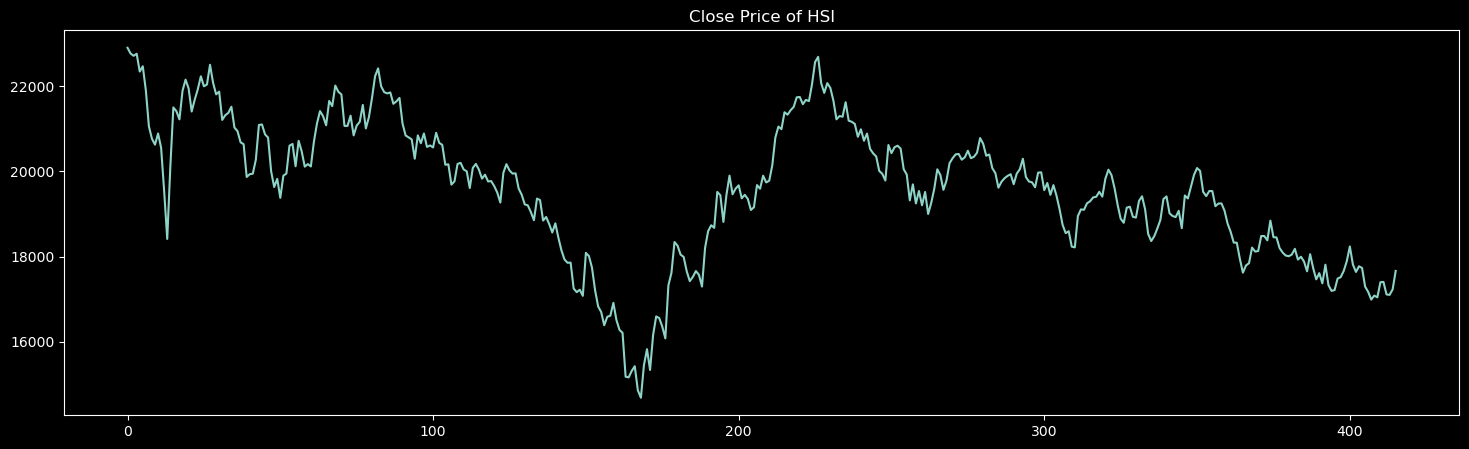

In [5]:
plt.subplots(figsize=(18,5))
plt.title(f'Close Price of HSI')
plt.plot(macd_df.Close)

In [6]:
# contruct return and balance 
init_balance = 10_000 
macd_df['Return'] = macd_df['Close'] / macd_df['Close'].shift(1)
macd_df.loc[0, 'Return'] = 1

macd_df['Balance'] = init_balance * macd_df['Return']

In [7]:
macd_df

,Close,Up votes,Down votes,Return,Balance
0,22901.56,0.36,0.64,1.000000,10000.000000
1,22767.18,0.61,0.39,0.994132,9941.322775
2,22713.02,0.49,0.51,0.997621,9976.211371
3,22761.71,0.48,0.52,1.002144,10021.437044
4,22343.92,0.50,0.50,0.981645,9816.450522
...,...,...,...,...,...
411,17406.36,0.61,0.39,1.000481,10004.805150
412,17112.48,0.42,0.58,0.983117,9831.165160
413,17101.78,0.51,0.49,0.999375,9993.747253
414,17230.59,0.67,0.33,1.007532,10075.319645


In [8]:
# Compute the drawdown 

macd_df['Bal_Peak'] = macd_df['Balance'].cummax()

macd_df['Bal_DD'] = macd_df['Balance'] - macd_df['Bal_Peak']

bal_dd = round((macd_df.Bal_DD / macd_df.Bal_Peak).min() * 100, 2)

bal_dd

-14.15

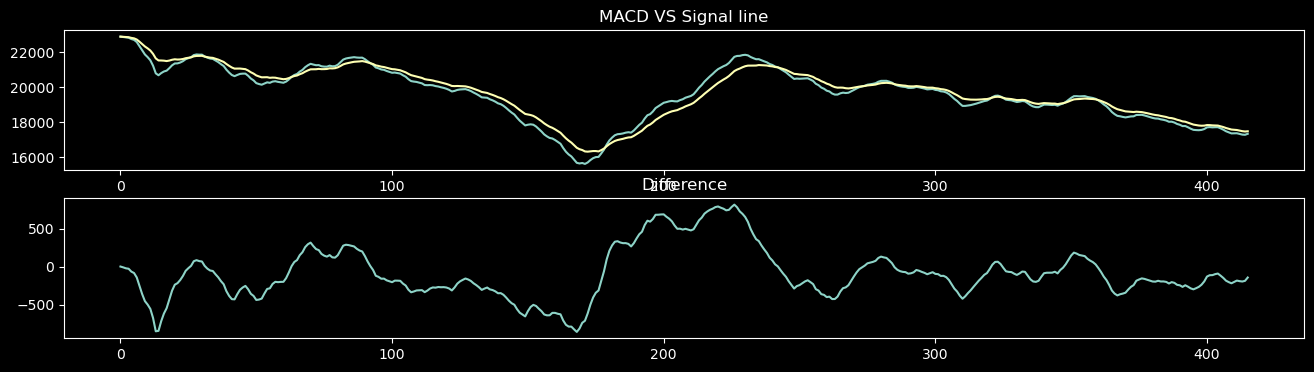

In [9]:
# Compute the MACD 
macd_line = macd_df['Close'].ewm(span = 12, adjust=False).mean()
signal_line = macd_df['Close'].ewm(span = 26, adjust=False).mean()

diff_line = macd_line - signal_line

fig, axs = plt.subplots(2,1,figsize=(16,4))
axs[0].set_title(f'MACD VS Signal line')
axs[0].plot(macd_line)
axs[0].plot(signal_line)

axs[1].set_title('Difference')
axs[1].plot(diff_line)


In [27]:
from backtesting import Backtest, Strategy 
from backtesting.lib import crossover
from backtesting.test import SMA

df.index = pd.to_datetime(df.index)

class SmaCross(Strategy):
    n1 = 12
    n2 = 26

    def init(self):
        close = self.data['Close']
        self.sma1 = self.I(SMA, close, self.n1)
        self.sma2 = self.I(SMA, close, self.n2)

    def next(self):
        up_votes = self.data['Up votes']
        if crossover(self.sma1, self.sma2) and up_votes < 0.8:
            self.buy()
        elif crossover(self.sma2, self.sma1) and up_votes > 0.1:
            self.sell()


bt = Backtest(df, SmaCross,
              cash=df['Close'].max(), commission=.002,
              exclusive_orders=True)

In [28]:
output = bt.run()
bt.plot()

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/var/folders/vw/lj0skyts0653xv3_004mgtm80000gn/T/ipykernel_55248/3786367488.py:2: UserWarning: 'Can't superimpose OHLC data with rule 'None'(index datetime resolution: 'nanosecond'). Skipping.
  bt.plot()
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/s

GridPlot(id='p2391', ...)

In [24]:
print(output)

Start                     1970-01-01 00:00:00
End                       1970-01-01 00:00...
Duration                  0 days 00:00:00....
Exposure Time [%]                   92.067308
Equity Final [$]                  25267.17204
Equity Peak [$]                    28915.7798
Return [%]                           10.32948
Buy & Hold Return [%]              -22.869359
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -14.733356
Avg. Drawdown [%]                    -4.07711
Max. Drawdown Duration    0 days 00:00:00....
Avg. Drawdown Duration    0 days 00:00:00....
# Trades                                   17
Win Rate [%]                        41.176471
Best Trade [%]                      15.940007
Worst Trade [%]                     -5.296677
Avg. Trade [%]                    

In [52]:
import numpy as np
from backtesting import Strategy
from backtesting.lib import crossover

def EMA(values, period):
    weights = np.exp(np.linspace(-1., 0., period))
    weights /= weights.sum()
    a = np.convolve(values, weights, mode='full')[:len(values)]
    a[:period] = a[period]
    return a

class EmaCross(Strategy):
    short_period = 12
    long_period = 26

    def init(self):
        close = self.data.Close
        # Calculate EMAs using the EMA function
        self.ema_short = self.I(EMA, close, self.short_period)
        self.ema_long = self.I(EMA, close, self.long_period)

    def next(self):
        up_votes = self.data['Up votes']
        if crossover(self.ema_short, self.ema_long) & (up_votes <=  0.65):
            self.buy()
        elif crossover(self.ema_long, self.ema_short) & (up_votes >  0.5):
            self.sell()

In [53]:
bt = Backtest(df, EmaCross,
              cash=df['Close'].max(), commission=.002,
              exclusive_orders=True)

output = bt.run()
bt.plot()

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/var/folders/vw/lj0skyts0653xv3_004mgtm80000gn/T/ipykernel_55248/3905964119.py:6: UserWarning: 'Can't superimpose OHLC data with rule 'None'(index datetime resolution: 'nanosecond'). Skipping.
  bt.plot()
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/s

GridPlot(id='p4655', ...)

In [54]:
print(output)

Start                     1970-01-01 00:00:00
End                       1970-01-01 00:00...
Duration                  0 days 00:00:00....
Exposure Time [%]                   96.394231
Equity Final [$]                  26182.47494
Equity Peak [$]                   30757.02854
Return [%]                          14.326164
Buy & Hold Return [%]              -22.869359
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -16.108881
Avg. Drawdown [%]                   -3.876672
Max. Drawdown Duration    0 days 00:00:00....
Avg. Drawdown Duration    0 days 00:00:00....
# Trades                                    9
Win Rate [%]                        66.666667
Best Trade [%]                      13.642441
Worst Trade [%]                     -6.415771
Avg. Trade [%]                    